# Pre-processing Step 1
## Reading Trajectory Data
First we start by reading trajectory data using PTRAIL, which will provide the data structures necessary to handle the spatio-temporal dependencies on the data.

In [1]:
import pandas as pd
from ptrail.core.TrajectoryDF import PTRAILDataFrame
from ptrail.preprocessing.statistics import Statistics
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
from ptrail.features.semantic_features import SemanticFeatures

pdf = pd.read_csv('./starkey_new.csv')
starkey = PTRAILDataFrame(data_set=pdf,
                          latitude='lat',
                          longitude='lon',
                          datetime='DateTime',
                          traj_id='Id')
print(starkey)


------------------------ Dataset Facts ------------------------------

Number of unique Trajectories in the data: 253
Number of points in the data: 287136
Dataset time range: 1196 days 22:51:45
Datatype of the DataFrame: <class 'ptrail.core.TrajectoryDF.PTRAILDataFrame'>
Dataset Bounding Box: (45.18896978643169, -118.61020848239596, 45.314545642992, -118.50455596234036)

---------------------------------------------------------------------


# Pre-processing Step 2
## Create Trajectory Features

Generate the kinematic statistics.
This method creates first a point-based representation for features: distance between points distance travelled from start, speed (m/s), acceleration (m/s2), jerk, bearing, bearing rate, and rate of bearing rate (8 point features).
After, the method extracts statistics from all these features, including:
minimum, maximal, standard deviation, mean, and percentiles 10, 25, 50, 75 and 90.
The statistics extracted are a trajectory(segment)-based representation of the trajectory dataset and can be used for several problems.
For data visualization purposes, the outcomes of this method are grouped by
point-feature attribute.

In [2]:
%%time

# generate Kinematic stats.
stats = Statistics.generate_kinematic_stats(dataframe=starkey,
                                            target_col_name='Species')
stats

CPU times: user 31.2 s, sys: 835 ms, total: 32.1 s
Wall time: 33.6 s


mean           std           min  \
traj_id   Columns                                                          
910313E37 Distance              2.687290e+02  3.989020e+02  0.000000e+00   
          Distance_from_start   2.991414e+03  1.502135e+03  6.709068e+01   
          Speed                 9.028607e-02  3.516819e-01  0.000000e+00   
          Acceleration          1.694076e-04  3.804985e-03 -3.871767e-03   
          Jerk                  2.368492e-06  7.500795e-05 -6.192481e-05   
...                                      ...           ...           ...   
950227D02 Acceleration          3.073895e-07  2.813300e-06 -8.201602e-06   
          Jerk                  2.522181e-11  5.492696e-10 -1.745441e-09   
          Bearing               1.715773e+02  1.089281e+02  0.000000e+00   
          Bearing_Rate         -5.649395e-06  2.092258e-02 -4.111534e-02   
          Rate_of_bearing_rate -5.649395e-06  2.092258e-02 -4.111534e-02   

                                         10%           25%           50%  \
traj_id   Columns                                                          
910313E37 Distance              3.002236e+01  6.695679e+01  1.496120e+02   
          Distance_from_start   1.121185e+03  1.910512e+03  2.897754e+03   
          Speed                 8.259408e-03  1.615503e-02  3.359295e-02   
          Acceleration         -2.424220e-05 -6.195019e-06 -1.586024e-08   
          Jerk                 -1.388547e-08 -2.115955e-09  3.702679e-10   
...                                      ...           ...           ...   
950227D02 Acceleration         -1.521129e-06 -6.963304e-07  1.091238e-07   
          Jerk                 -4.773323e-10 -1.682445e-10  1.565389e-11   
          Bearing               2.581650e+01  7.594447e+01  1.918598e+02   
          Bearing_Rate         -2.710110e-02 -1.447030e-02 -4.449623e-04   
          Rate_of_bearing_rate -2.710110e-02 -1.447030e-02 -4.449623e-04   

                                         75%           90%           max  \
traj_id   Columns                                                          
910313E37 Distance              3.007269e+02  6.322696e+02  6.034208e+03   
          Distance_from_start   3.756909e+03  5.051656e+03  8.113438e+03   
          Speed                 7.204029e-02  1.547846e-01  1.197764e+01   
          Acceleration          7.442440e-06  2.916966e-05  1.869186e-01   
          Jerk                  4.593905e-09  1.898648e-08  3.555295e-03   
...                                      ...           ...           ...   
950227D02 Acceleration          1.316340e-06  2.287033e-06  1.151525e-05   
          Jerk                  1.988293e-10  4.681268e-10  1.654699e-09   
          Bearing               2.568528e+02  3.123812e+02  3.588820e+02   
          Bearing_Rate          9.538988e-03  2.971413e-02  4.730803e-02   
          Rate_of_bearing_rate  9.538988e-03  2.971413e-02  4.730803e-02   

                                Species  
traj_id   Columns                        
910313E37 Distance                    1  
          Distance_from_start         1  
          Speed                       1  
          Acceleration                1  
          Jerk                        1  
...                                 ...  
950227D02 Acceleration                0  
          Jerk                        0  
          Bearing                     0  
          Bearing_Rate                0  
          Rate_of_bearing_rate        0  

[2024 rows x 10 columns]

# Pre-processing Step 3
## Pivot the frame to create a feature vector
To change the representation in a way we can assign one label per trajectory (segment)
The user just need to call the method pivot_stats_df and all trajectory-based features will be pivoted for machine learning tasks as can be seen below

In [3]:
# Pivot the stats df and get it ready for the ML task.
pivoted_stats = Statistics.pivot_stats_df(dataframe=stats,
                                          target_col_name='Species')
pivoted_stats

,10%_Distance,25%_Distance,50%_Distance,75%_Distance,90%_Distance,min_Distance,max_Distance,mean_Distance,std_Distance,10%_Distance_from_start,...,10%_Rate_of_bearing_rate,25%_Rate_of_bearing_rate,50%_Rate_of_bearing_rate,75%_Rate_of_bearing_rate,90%_Rate_of_bearing_rate,min_Rate_of_bearing_rate,max_Rate_of_bearing_rate,mean_Rate_of_bearing_rate,std_Rate_of_bearing_rate,Species
traj_id,,,,,,,,,,,,,,,,,,,,,
910313E37,30.022359,66.956787,149.611989,300.726867,632.269559,0.000000,6034.207873,268.728974,398.901980,1121.185006,...,-0.063322,-0.026677,5.306679e-08,0.025072,0.065316,-6.036678,2.449554,-0.001945,0.154034,1
890424E08,42.384642,84.780370,177.223376,379.614004,759.311144,0.000000,6043.490157,323.956468,446.249248,674.170024,...,-0.064023,-0.023545,0.000000e+00,0.022320,0.063820,-11.536372,2.494857,-0.006703,0.241358,1
921228E06,42.390114,90.066813,200.849995,429.158672,890.194719,0.000000,4623.347553,377.677630,517.650637,807.693739,...,-0.058033,-0.020736,-9.056581e-07,0.020104,0.056057,-56.020652,4.466711,-0.016681,1.008263,1
930304E16,42.384012,67.090258,153.068542,341.254645,690.640774,0.000000,5864.020183,291.351804,396.220730,1156.455188,...,-0.068092,-0.026542,2.094546e-07,0.027375,0.066328,-7.865121,30.406105,0.001768,0.600187,1
940110D01,30.022192,66.956668,149.612107,284.710015,510.276991,0.000000,1975.611748,221.420080,235.093739,492.522877,...,-0.041207,-0.018263,0.000000e+00,0.018564,0.042032,-5.547235,200.192244,0.073830,3.677063,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
OSUX92071,42.384783,98.213522,275.921086,509.415791,1734.539050,0.000000,4968.850596,552.252200,797.302786,2019.896767,...,-0.013195,-0.006290,-1.456657e-04,0.006863,0.019363,-0.180602,0.032870,-0.001012,0.022347,2
OSUX92008,60.044073,113.846901,323.971240,582.606358,1036.441333,0.000000,3252.044721,469.226709,565.038959,2330.556507,...,-0.033016,-0.006065,4.739615e-05,0.008182,0.023711,-0.119311,0.119162,-0.001884,0.033022,2
OSUX91121,66.956676,138.476526,334.746006,596.234364,1365.947767,42.390056,5886.617958,652.055638,1119.869470,2660.409775,...,-0.010799,-0.003606,1.840711e-04,0.006951,0.023679,-0.018316,0.027926,0.001982,0.011728,2


# Pre-processing Step 4
## Feature Selection

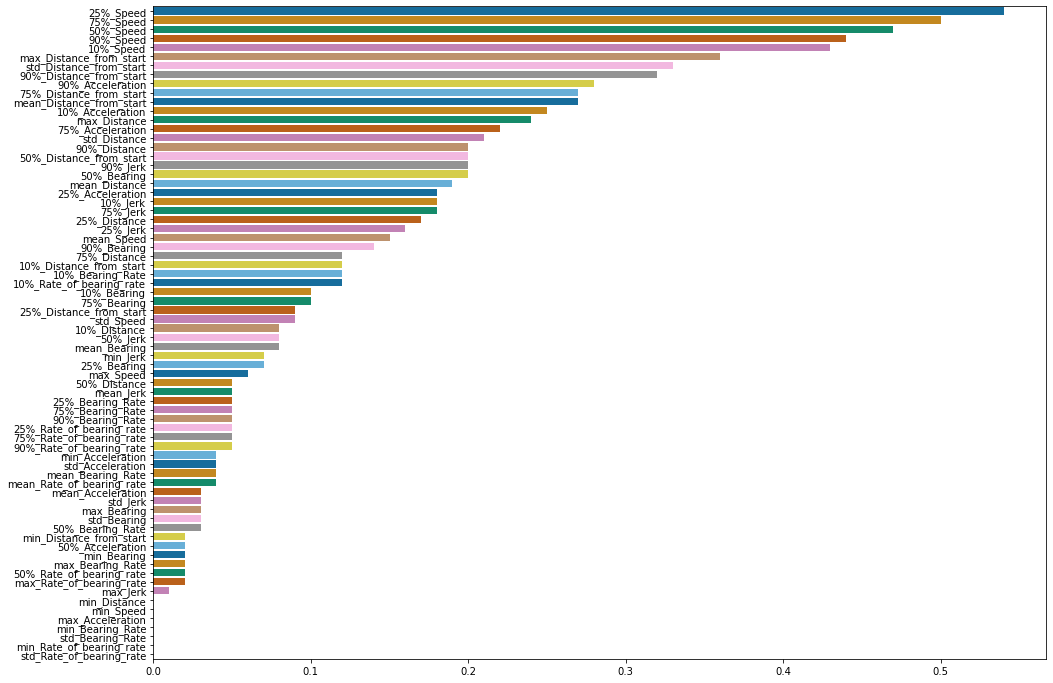

In [4]:
# Visualization tools.
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-selecting features
from sklearn.feature_selection import mutual_info_classif
from operator import itemgetter
import numpy as np

# Convert the dataframe and its answer value to numpy.
X = pivoted_stats.drop(columns='Species').to_numpy()
Y = pivoted_stats['Species'].to_numpy()

mutual_info = mutual_info_classif(X,Y)
feat_list = []
for column, minfo in zip(pivoted_stats.columns, mutual_info):
  feat_list.append([column, round(minfo, 2)])

# Sort the selected features and then convert it to a numpy array
# and make sure that the datatypes are correctly assigned.
sorted_flist = sorted(feat_list, key=itemgetter(1), reverse=True)
flist = np.array(sorted_flist)
f_names = flist[:,0].astype(np.unicode_)
minfo = flist[:,1].astype(np.float16)

fig, ax = plt.subplots(figsize=(16, 12))
sns.barplot(x=minfo, y=f_names, ax=ax, palette='colorblind')

# select elements greater than .20
final_list = [i for i in sorted_flist if i[1] >= .2]
selected_cols = [i[0] for i in final_list]

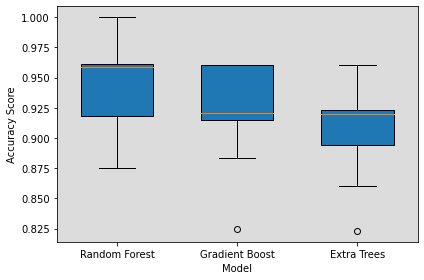

In [5]:
# Models.
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

# Metric calculation.
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# Declare all the models that we are going to train.
names = ["Random Forest", "Gradient Boost", "Extra Trees"]
models = [RandomForestClassifier(), ExtraTreesClassifier(),
          GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=1, random_state=0)]

# Convert the dataframe and its answer value to numpy.
X = pivoted_stats[selected_cols]
Y = pivoted_stats['Species'].to_numpy()

ax = plt.subplot(111)
ax.set_facecolor('gainsboro')

skf = StratifiedKFold(n_splits=10, random_state=None, shuffle=True)
# For each model defined above, predict the species for
# our animals.
for i, name, model in zip(range(0, 4), names, models):
    fit = model.fit(X, Y)
    scores = cross_val_score(model, X, Y,
                             scoring='f1_weighted', cv=skf, n_jobs=-1)
    ax.boxplot(x=scores, positions=[i],
               vert=True, widths=0.60, patch_artist=True)

ax.set_xticklabels(labels=names)
ax.set_ylabel("Accuracy Score")
ax.set_xlabel("Model")
plt.tight_layout()

<function amin at 0x7f97b80b54c0>
<function amin at 0x7f97b80b54c0>
<function amin at 0x7f97b80b54c0>


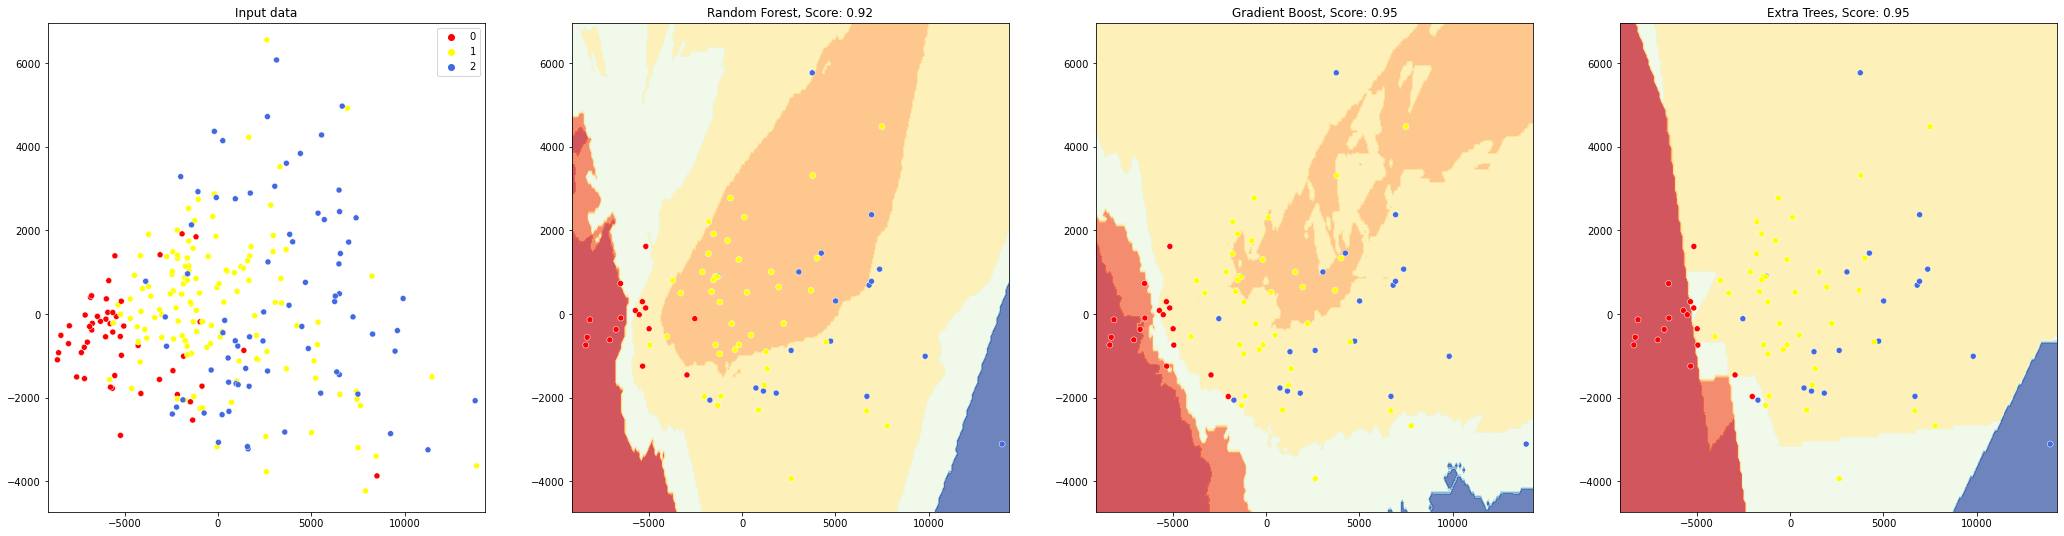

In [6]:
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

# Perform PCA on our df and extract 2 components for visualization purposes.
pca2 = PCA(n_components=2)
transformed2 = pca2.fit_transform(X=X)

# Prepare next figure
fig2, ax2 = plt.subplots(1, 4, figsize=(36, 9))
fig2.set_facecolor('white')
ax2=ax2.flatten()

h = 100
x_min, x_max = transformed2[:, 0].min() - 500, transformed2[:, 0].max() + 500
y_min, y_max = transformed2[:, 1].min() - 500, transformed2[:, 1].max() + 500
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# just plot the dataset first
cm = plt.cm.RdYlBu
cm_bright = ListedColormap(["#FF0000", "#FFFF00", "#00FF00"])

ax2[0].set_title("Input data")
# Plot all points of the dataset.
sns.scatterplot(x=transformed2[:, 0], y=transformed2[:, 1],
                hue=Y, ax=ax2[0], palette=['red', 'yellow', 'royalblue'])
ax2[0].set_xlim(xx.min(), xx.max())
ax2[0].set_ylim(yy.min(), yy.max())
# ax2[0].get_legend().remove()

for i, name, model in zip(range(1, len(ax2)), names, models):
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    hue = model.predict(X_test)

    # Convert the mesh back to the original values.
    real_X = pca2.inverse_transform(np.c_[xx.ravel(), yy.ravel()])
    print(np.min)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z_vals = model.predict_proba(real_X)

    # Now we will perform the calculation for the
    # colormap gradient and then convert the list to a numpy array.
    Z = []
    for j in range(len(Z_vals)):
        val = (np.argmax(Z_vals[j]) + 1) - Z_vals[j][np.argmax(Z_vals[j])]
        Z.append(val)
    Z = np.array(Z)

    # Scale the z-values to be between 0 and 2.
    scaler = MinMaxScaler(feature_range=(0, 2))
    scaler.fit(Z.reshape(-1, 1))
    Z = scaler.transform(Z.reshape(-1, 1))

    # Reshape the array and then plot the contour plot.
    Z = Z.reshape(xx.shape)
    ax2[i].contourf(xx, yy, Z, cmap=cm, alpha=0.75)

    # Now, we plot the points onto the contour and then map their
    # colors according to the regions.
    sns.scatterplot(x=pca2.fit_transform(X_test)[:, 0], y=pca2.fit_transform(X_test)[:, 1],
                    hue=hue, ax=ax2[i], palette=['red', 'yellow', 'royalblue'])

    ax2[i].set_title(name + f', Score: {round(score, 2)}')
    ax2[i].get_legend().remove()

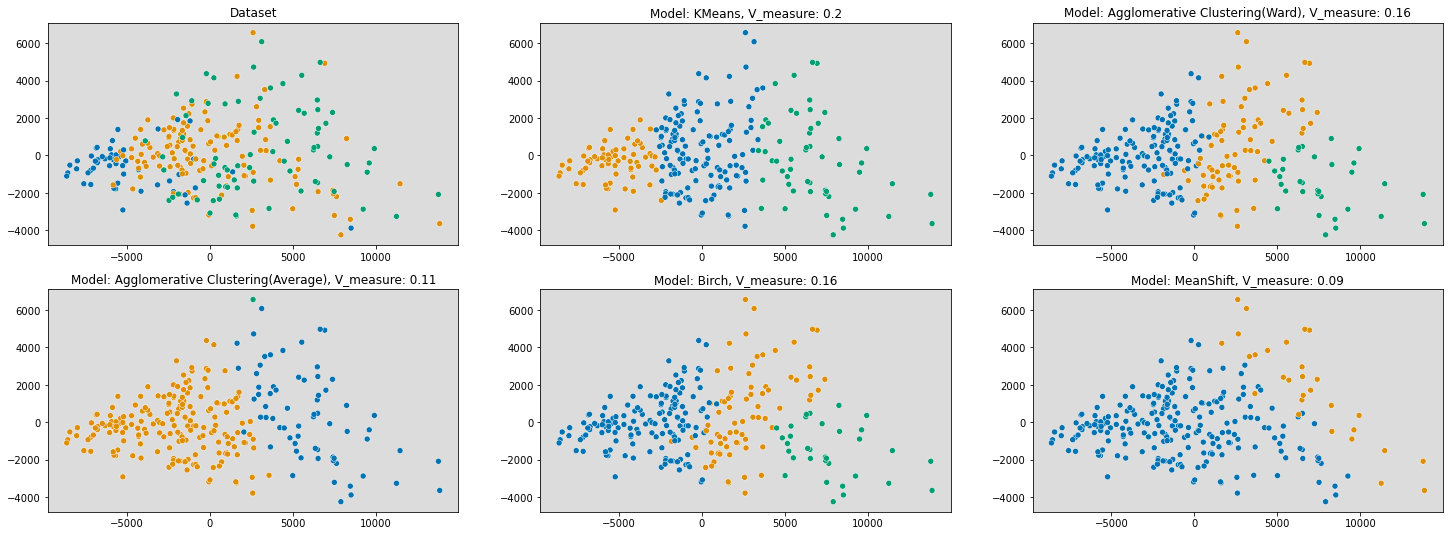

In [7]:
# 2. Clustering Pipeline.
# from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, Birch, KMeans, AgglomerativeClustering, estimate_bandwidth
from sklearn.metrics import v_measure_score

# estimate bandwidth for mean shift
bandwidth = estimate_bandwidth(X, quantile=0.25)

cluster_models = [
    KMeans(n_clusters=3, algorithm='elkan'),
    AgglomerativeClustering(n_clusters=3),
    AgglomerativeClustering(linkage="average", n_clusters=3),
    Birch(n_clusters=3),
    MeanShift(bandwidth=bandwidth, bin_seeding=True),
]

cluster_names = ['KMeans', 'Agglomerative Clustering(Ward)', 'Agglomerative Clustering(Average)', 'Birch', 'MeanShift']

# Perform PCA on our df and extract 2 components for visualization purposes.
pca = PCA(n_components=2)
transformed = pca.fit_transform(X=X)

# Plot true clusters
# sns.scatterplot(x=transformed[:, 0], y=transformed[:, 1],
                    # hue=Y, palette='colorblind')


# Prepare next figure
fig1, ax1 = plt.subplots(2, 3, figsize=(25, 9))
fig1.set_facecolor('white')
ax1=ax1.flatten()

sns.scatterplot(x=transformed[:, 0], y=transformed[:, 1], hue=Y, palette='colorblind', ax=ax1[0])
ax1[0].set_title(f'Dataset')
ax1[0].get_legend().remove()
ax1[0].set_facecolor('gainsboro')

# Training the models first and doing their box plots.
for i, name, model in zip(range(0, len(ax1)), cluster_names, cluster_models):
    # Predict the species on the test dataset.
    ans = model.fit_predict(X)
    # calculating v_measure
    score = v_measure_score(Y, model.labels_)
    # Plot the 2D scatterplot and then set the title of each plot.
    sns.scatterplot(x=transformed[:, 0], y=transformed[:, 1],
                    hue=ans, palette='colorblind', ax=ax1[i+1])
    ax1[i+1].set_title(f'Model: {name}, V_measure: {round(score, 2)}')
    ax1[i+1].get_legend().remove()
    ax1[i+1].set_facecolor('gainsboro')

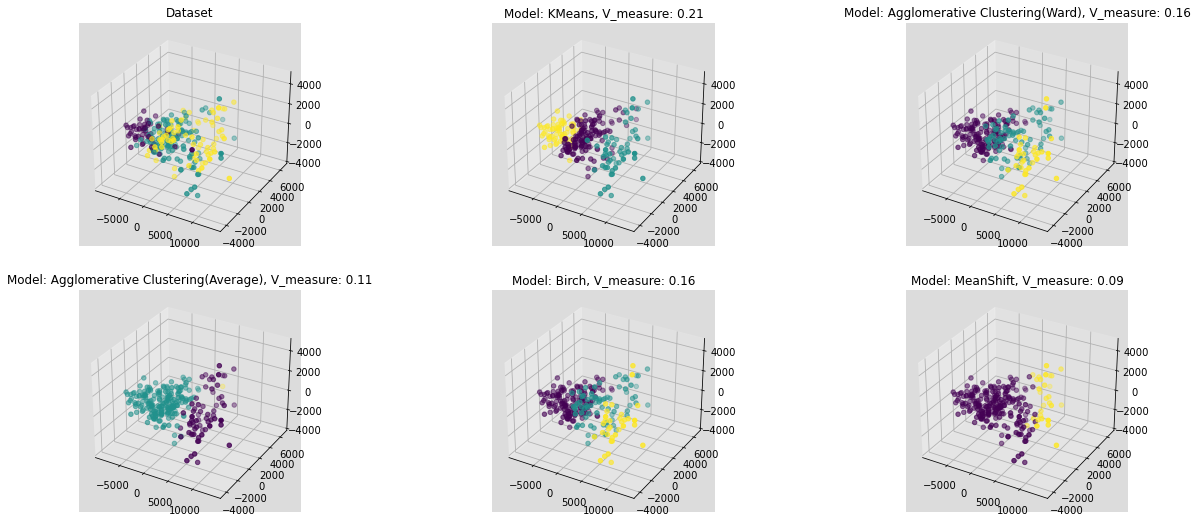

In [8]:
# 2. Clustering Pipeline.
# from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, Birch, KMeans, AgglomerativeClustering, estimate_bandwidth
from sklearn.metrics import  v_measure_score
from mpl_toolkits.mplot3d import axes3d


# estimate bandwidth for mean shift
bandwidth = estimate_bandwidth(X, quantile=0.25)

cluster_models = [
    KMeans(n_clusters=3, algorithm='elkan'),
    AgglomerativeClustering(n_clusters=3),
    AgglomerativeClustering(linkage="average", n_clusters=3),
    Birch(n_clusters=3),
    MeanShift(bandwidth=bandwidth, bin_seeding=True),
]

cluster_names = ['KMeans', 'Agglomerative Clustering(Ward)', 'Agglomerative Clustering(Average)', 'Birch', 'MeanShift']

# Perform PCA on our df and extract 2 components for visualization purposes.
pca = PCA(n_components=3)
transformed = pca.fit_transform(X=X)

# Prepare next figure
fig1, ax1 = plt.subplots(2, 3, figsize=(21, 9), subplot_kw={'projection': '3d'})
fig1.set_facecolor('white')
ax1 = ax1.flatten()

ax1[0].scatter(transformed[:, 0], transformed[:, 1], transformed[:, 2], marker='o', c=Y)
ax1[0].set_title(f'Dataset')
ax1[0].set_facecolor('gainsboro')

# Training the models first and doing their box plots.
for i, name, model in zip(range(0, len(ax1)), cluster_names, cluster_models):
    # Predict the species on the test dataset.
    ans = model.fit_predict(X)
    # calculating v_measure
    score = v_measure_score(Y, model.labels_)

    # Plot the 3D scatterplot and then set the title of each plot.
    ax1[i + 1].scatter(transformed[:, 0], transformed[:, 1], transformed[:, 2], marker='o', c=ans)
    ax1[i+1].set_title(f'Model: {name}, V_measure: {round(score, 2)}')
    ax1[i+1].set_facecolor('gainsboro')

In [9]:
three_month_seg = Statistics.segment_traj_by_days(starkey, 90)
three_month_seg

lat         lon  StarkeyTime  \
traj_id   seg_id DateTime                                                  
880119D02 1      1993-05-18 14:04:36  45.245158 -118.527618    169855476   
                 1993-05-18 14:41:26  45.244873 -118.528757    169857686   
                 1993-05-18 15:17:29  45.245148 -118.528382    169859849   
                 1993-05-18 15:54:58  45.243803 -118.527964    169862098   
                 1993-05-18 17:05:50  45.243814 -118.527199    169866350   
...                                         ...         ...          ...   
OSUX89078 4      1994-08-14 13:44:33  45.205146 -118.550994    208993473   
                 1994-08-14 15:59:32  45.202099 -118.556641    209001572   
                 1994-08-14 18:09:31  45.204591 -118.552125    209009371   
                 1994-08-14 22:36:21  45.201112 -118.549739    209025381   
                 1994-08-15 14:36:20  45.197136 -118.544284    209082980   

                                        GMDate    GMTime   LocDate   LocTime  \
traj_id   seg_id DateTime                                                      
880119D02 1      1993-05-18 14:04:36  22:04:36  19930518  19930518  14:04:36   
                 1993-05-18 14:41:26  22:41:26  19930518  19930518  14:41:26   
                 1993-05-18 15:17:29  23:17:29  19930518  19930518  15:17:29   
                 1993-05-18 15:54:58  23:54:58  19930518  19930518  15:54:58   
                 1993-05-18 17:05:50  01:05:50  19930519  19930518  17:05:50   
...                                        ...       ...       ...       ...   
OSUX89078 4      1994-08-14 13:44:33  21:44:33  19940814  19940814  13:44:33   
                 1994-08-14 15:59:32  23:59:32  19940814  19940814  15:59:32   
                 1994-08-14 18:09:31  02:09:31  19940815  19940814  18:09:31   
                 1994-08-14 22:36:21  06:36:21  19940815  19940814  22:36:21   
                 1994-08-15 14:36:20  22:36:20  19940815  19940815  14:36:20   

                                      RadNum  Species    UTME     UTMN  Year  \
traj_id   seg_id DateTime                                                      
880119D02 1      1993-05-18 14:04:36     187        0  380126  5011313    93   
                 1993-05-18 14:41:26     187        0  380019  5011283    93   
                 1993-05-18 15:17:29     187        0  380064  5011312    93   
                 1993-05-18 15:54:58     187        0  380084  5011165    93   
                 1993-05-18 17:05:50     187        0  380132  5011164    93   
...                                      ...      ...     ...      ...   ...   
OSUX89078 4      1994-08-14 13:44:33     172        2  378203  5006910    94   
                 1994-08-14 15:59:32     172        2  377745  5006567    94   
                 1994-08-14 18:09:31     172        2  378096  5006846    94   
                 1994-08-14 22:36:21     172        2  378286  5006473    94   
                 1994-08-15 14:36:20     172        2  378701  5005995    94   

                                      Grensunr  Grensuns  Obswt        Date  
traj_id   seg_id DateTime                                                    
880119D02 1      1993-05-18 14:04:36  12:21:00  03:23:00   1.39  1993-05-18  
                 1993-05-18 14:41:26  12:21:00  03:23:00   1.39  1993-05-18  
                 1993-05-18 15:17:29  12:21:00  03:23:00   1.39  1993-05-18  
                 1993-05-18 15:54:58  12:21:00  03:23:00   1.39  1993-05-18  
                 1993-05-18 17:05:50  12:20:00  03:24:00   1.39  1993-05-18  
...                                        ...       ...    ...         ...  
OSUX89078 4      1994-08-14 13:44:33  12:55:00  03:06:00   1.74  1994-08-14  
                 1994-08-14 15:59:32  12:55:00  03:06:00   1.72  1994-08-14  
                 1994-08-14 18:09:31  12:56:00  03:04:00   1.74  1994-08-14  
                 1994-08-14 22:36:21  12:56:00  03:04:00   1.66  1994-08-14  
                 1994-08-15 14:36:20 

In [10]:
three_month_seg['Species'].value_counts()

1    365511
0    209912
2    208100
Name: Species, dtype: int64

In [11]:
%%time

segment_stats = Statistics.generate_kinematic_stats(dataframe=three_month_seg,
                                                    target_col_name='Species',
                                                    segmented=True)
segment_stats

CPU times: user 11min 48s, sys: 2.86 s, total: 11min 51s
Wall time: 11min 44s


mean          std        min  \
traj_id   seg_id Columns                                                     
910313E37 1      Distance               268.728974   398.901980   0.000000   
                 Distance_from_start   2991.413513  1502.135300  67.090679   
                 Speed                    0.090286     0.351682   0.000000   
                 Acceleration             0.000142     0.003236  -0.002575   
                 Jerk                     0.000003     0.000092  -0.000060   
...                                            ...          ...        ...   
890504E01 1      Acceleration             0.000475     0.006004  -0.003082   
                 Jerk                     0.000005     0.000060  -0.000026   
                 Bearing                176.038961   105.938864   0.000000   
                 Bearing_Rate             0.007660     0.133692  -0.395180   
                 Rate_of_bearing_rate     0.007660     0.133692  -0.395180   

                                                10%           25%  \
traj_id   seg_id Columns                                            
910313E37 1      Distance              3.002236e+01  6.695679e+01   
                 Distance_from_start   1.121185e+03  1.910512e+03   
                 Speed                 8.259408e-03  1.615503e-02   
                 Acceleration         -3.693436e-05 -1.135711e-05   
                 Jerk                 -2.742025e-08 -6.272285e-09   
...                                             ...           ...   
890504E01 1      Acceleration         -1.530121e-05 -2.809400e-06   
                 Jerk                 -6.462419e-09 -9.536095e-10   
                 Bearing               3.542670e+01  8.098514e+01   
                 Bearing_Rate         -5.225987e-02 -1.745584e-02   
                 Rate_of_bearing_rate -5.225987e-02 -1.745584e-02   

                                                50%           75%  \
traj_id   seg_id Columns                                            
910313E37 1      Distance              1.496120e+02  3.007269e+02   
                 Distance_from_start   2.897754e+03  3.756909e+03   
                 Speed                 3.359295e-02  7.204029e-02   
                 Acceleration         -1.454121e-07  1.307407e-05   
                 Jerk                  1.499050e-09  1.182897e-08   
...                                             ...           ...   
890504E01 1      Acceleration         -2.838473e-08  4.717288e-06   
                 Jerk                  5.523722e-11  2.553449e-09   
                 Bearing               1.788900e+02  2.616095e+02   
                 Bearing_Rate         -8.483334e-08  1.785239e-02   
                 Rate_of_bearing_rate -8.483334e-08  1.785239e-02   

                                                90%          max  Species  
traj_id   seg_id Columns                                                   
910313E37 1      Distance              6.322696e+02  6034.207873        1  
                 Distance_from_start   5.051656e+03  8113.437916        1  
                 Speed                 1.547846e-01    11.977635        1  
                 Acceleration          4.602752e-05     0.110223        1  
                 Jerk                  4.170634e-08     0.003555        1  
...                                             ...          ...      ...  
890504E01 1      Acceleration          2.007150e-05     0.081134        1  
                 Jerk                  1.060334e-08     0.000844        1  
                 Bearing               3.206870e+02   358.880193        1  
                 Bearing_Rate          5.017318e-02     2.031544        1  
                 Rate_of_bearing_rate  5.017318e-02     2.031544        1  

[7608 rows x 10 columns]

In [21]:
pivoted = Statistics.pivot_stats_df(dataframe=segment_stats, target_col_name='Species', segmented=True)
pivoted

10%_Distance  25%_Distance  50%_Distance  75%_Distance  \
traj_id   seg_id                                                           
910313E37 1          30.022359     66.956787    149.611989    300.726867   
          2          42.384443     67.091031    153.061613    341.246993   
          3          42.384424     67.090887    152.598455    335.424228   
          4          42.384424     67.090887    152.598455    335.424228   
          5          42.384443     84.768805    152.598947    329.145772   
...                        ...           ...           ...           ...   
910315E17 1          59.844765    108.133713    273.440870    615.793296   
921228E02 1          66.948571    134.180505    366.043181    672.728499   
910315E04 1          67.090172    125.458700    276.738301    605.340878   
921215E02 1          42.389318     94.903889    307.203326    615.614161   
890504E01 1          30.022193     71.509428    177.222789    486.818197   

                  90%_Distance  min_Distance  max_Distance  mean_Distance  \
traj_id   seg_id                                                            
910313E37 1         632.269559           0.0   6034.207873     268.728974   
          2         698.560846           0.0   6034.207873     300.744754   
          3         693.087596           0.0   7199.456789     293.252709   
          4         693.087596           0.0   7199.456789     293.252709   
          5         676.510598           0.0   4797.540752     288.815558   
...                        ...           ...           ...            ...   
910315E17 1        1154.357313           0.0   4338.931125     495.311475   
921228E02 1        1204.591285           0.0   6198.581476     539.957720   
910315E04 1        1142.347183           0.0   3572.040963     479.929578   
921215E02 1        1276.676188           0.0   7965.252752     516.744793   
890504E01 1        1023.547812           0.0   5656.561638     417.359827   

                  std_Distance  10%_Distance_from_start  ...  \
traj_id   seg_id                                         ...   
910313E37 1         398.901980              1121.185006  ...   
          2         430.321000              1044.019619  ...   
          3         413.384959              1034.216662  ...   
          4         413.384959              1034.216662  ...   
          5         394.835766              1081.685734  ...   
...                        ...                      ...  ...   
910315E17 1         636.179236               551.753482  ...   
921228E02 1         621.096955               554.819930  ...   
910315E04 1         547.215929              1529.101914  ...   
921215E02 1         693.199299               726.062099  ...   
890504E01 1         691.992678               788.625243  ...   

                  25%_Rate_of_bearing_rate  50%_Rate_of_bearing_rate  \
traj_id   seg_id                                                       
910313E37 1                       0.002923              2.194131e-02   
          2                            NaN                       NaN   
          3                            NaN                       NaN   
          4                            NaN                       NaN   
          5                            NaN                       NaN   
...                                    ...                       ...   
910315E17 1                      -0.009921             -9.650388e-05   
921228E02 1                      -0.008363              1.717982e-04   
910315E04 1                      -0.013323             -4.818033e-05   
921215E02 1                      -0.010656             -2.268710e-04   
890504E01 1                      -0.017456             -8.483334e-08   

                  75%_Rate_of_bearing_rate  90%_Rate_of_bearing_rate  \
traj_id   seg_id                                                       
910313E37 1                       0.052544                  0.086520   
          2                            Na